<a href="https://colab.research.google.com/github/allemanau/NUIT_tensorflow/blob/master/notebooks/4_Advanced_Techniques_and_Convolutional_Neural_Nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__4: Advanced Techniques and Convolutional Neural Nets__

## Learning Objectives

In this notebook, we'll learn...
- what a convolutional layer is, and why they work well for image data;
- how to specify and fit a convnet in TensorFlow via the Keras API
- use of data augmentation in image analysis

Although our previous model seems to work pretty well, it regards pixel values as independent features, since we flattened the images. In reality, pixels are spatially related, and by flattening the data, we ignore more complex spatial information beyond pixel-to-pixel relationships that may improve predictive power.

### Using a GPU runtime

Convolutional nets are more expensive to train than fully connected neural nets. We will use GPU acceleration for this notebook to speed the process along. GPUs are in favor with machine learning enthusiasts because they are quick to process tensors and convolve images (this is, after all, a GPU's full-time job).

## __What are Convolutional Neural Nets?__

The __convolutional neural network__ (or "convnet", or "CNN") uses alternating convolutional and max pooling layers to extract abstract features from image data.

### __Convolutional layer__

The workhorse in a CNN is the __convolutional layer__. The convolutional layer is composed of several __convolution filters__ (sometimes called "kernels"), which scan an image for certain shapes or features. A simplified example below illustrates how this works. When the "eye kernel" passes over an eye in the image, it activates, producing a large feature value:

![](https://i.stack.imgur.com/9bi5k.gif)

The kernel itself is a small matrix of weights, just a few pixels wide by a few pixels tall, and for color images, it has a depth equal to the number of color channels. It may seem from the example that kernels are complex, and thus need to be specified, but the weights for each kernel in the layer are actually learned by backpropagation.

### Convolution operation

Consider a  $3\times3$ filter for an image:

<img src="https://github.com/allemanau/NUIT_tensorflow/blob/master/images/conv_kernel.png?raw=1">

To get the convolution output, slide the filter over the image in each spot it fits, and take the weighted sum of the pixel values.

<br>

![](https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif)

<br>

The convolutional output is a tensor of size

<br>
\begin{equation*}
\text{(image width - filter width + 1)} \times \text{(image height - filter height + 1)} \times (\text{number of channels})
\end{equation*}
<br>

A layer is a collection of filters, each learning different features of the training images. Then, the size of the resulting convolutional layer will be

<br>
\begin{equation*}
\text{(image width - filter width + 1)} \times \text{(image height - filter height + 1)} \times (\text{number of channels} = 1) \times (\text{number of filters})
\end{equation*}
<br>

Organizing convolutional layers is something of an art. In general, the key thing to remember is that __larger filter sizes extract generic global features__, while __smaller filter sizes extract complex local features__. Using smaller filter sizes also enables construction of a deeper network, potentially yielding performance gains at the cost of increased training and prediction time.

### __Pooling__

One problem with convolutional filters is that they activate precisely where the feature appears. A __pooling layer__ solves this problem by dividing a convolution filter into __patches__ and summarizing the content of the filter in that region. An extrapolation of the simple example above helps to illustrate how a pooling layer captures the same signature from a shifted version of the image:

<br>

![](https://i0.wp.com/www.thushv.com/wp-content/uploads/2018/05/pooling.gif?resize=1100%2C829)

<br>

This particular variant of pooling is called __max pooling__; it takes the largest activation value from the convolution patch to be the feature value in the pooling layer.

### __Stacking convolutional and pooling layers to learn high level features__

With the two primary tools of a CNN in hand, the general principle is to apply a convolutional layer, then a pooling layer, then another convolutional layer, and so on. We will do this for the MNIST data set in a moment.

For novel problems, you can treat the layer sizes as parameters and tune them using a validation or cross-validation approach. Alternatively, you can adapt successful architectures others have built, [such as AlexNet](https://towardsdatascience.com/alexnet-the-architecture-that-challenged-cnns-e406d5297951), or even fine-tune the existing model for your problem via transfer learning (see the take-home exercise for more on this).



Although there are a few aspects and tricks of convolutional layers left unexplained, we have enough in hand to apply 2D convolutional and max pooling layers to MNIST.

In [1]:
# Load libraries
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, ActivityRegularization, Input, Reshape, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model, to_categorical

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Load MNIST data
mnist = tf.keras.datasets.mnist
(x_train, raw_y_train), (x_test, raw_y_test) = mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

x_train_scl = x_train / 255.0
x_test_scl = x_test / 255.0

y_train = to_categorical(raw_y_train, num_classes = 10)
y_test = to_categorical(raw_y_test, num_classes = 10)

loss_fn = 'categorical_crossentropy'
optim = 'adam'
batch_size = 500

conv_model = Sequential()
conv_model.add(Reshape((28, 28, 1)))
conv_model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(28,28)))
conv_model.add(Conv2D(64, (3, 3)))
conv_model.add(Activation('relu'))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Dropout(0.2))
conv_model.add(Flatten())
conv_model.add(Dense(128))
conv_model.add(Activation('relu'))
conv_model.add(Dropout(0.5))
conv_model.add(Dense(10))
conv_model.add(Activation('softmax'))

TensorFlow 2.x selected.
11493376/11490434 [==============================] - 0s 0us/step


In [0]:
conv_model.compile(optimizer = optim,
              loss = loss_fn,
              metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            patience=5, 
                                            restore_best_weights = True)

conv_model.fit(x_train_scl, 
          y_train, 
          #batch_size = 100,
          epochs = 50,
          validation_split = 0.1,
          callbacks = [callback])

Our convolutional model, along with the other improvements made along the way, demonstrates superior performance -- ~99% accurate! For reference, the best kernel on Kaggle for MNIST is 99.75% accurate (and is quite a bit more complicated).

In [0]:
conv_model.evaluate(x_test_scl,
               y_test)

Again, let's peek at a selection of mistakes.

In [0]:
# Get predicted classes.
preds = conv_model.predict_classes(x_test_scl)

# Prepare a figure for subplotting.
fig = plt.figure(figsize=(12, 6))

# Select one random misclass for each digit in the data set.
for i in range(10):
    ind = np.random.choice(np.ndarray.flatten(np.argwhere((y_test == i) & (y_test != preds))))
    actual = y_test[ind]
    predicted = preds[ind]
    plottable_image = np.reshape(x_test[ind], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')
    plt.xlabel("Actual: " + "{}".format(actual) + ", Predicted: " + "{}".format(predicted))

## __Data Augmentation__

An extremely useful trick to boost performance is to apply random __label-preserving transformations__ to create new training examples. These transformations include shifting and stretching images, adding small perturbations to the pixel values, and so on. This practice, called __data augmentation__, improves the ability of the model to generalize to unseen examples exhibiting these small changes. Keras provides an easy-to-use data augmentation toolkit. Let's explore it a bit on a single image:

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

The `ImageDataGenerator` object will ultimately replace our training set. The object uses a training set as a source to generate batches of new observations from dynamically. The list of label-preserving transformations are

- rotation
- positional shift
- brightness
- shear
- zoom
- vertical/horizontal flip
- others, see [`ImageDataGenerator` docs](https://keras.io/preprocessing/image/#imagedatagenerator-class)

Let's try a simple generator that only shifts observations:


In [0]:
# Can specify as a fraction of total width. Let's set to 30% to demonstrate:
train_gen = ImageDataGenerator(
    width_shift_range=0.3,
    height_shift_range=0.3)

for x_batch, y_batch in train_gen.flow(x_train, y_train, batch_size=9):
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(x_batch[i].reshape(28, 28), cmap = plt.get_cmap('gray'))
	plt.show()
	break

We can add rotation and shear if so desired:

In [0]:
# Rotation range is in degrees. Shear range is 
train_gen = ImageDataGenerator(
    rotation_range = 20,
    shear_range = 30,
    width_shift_range=0.15,
    height_shift_range=0.15)

for x_batch, y_batch in train_gen.flow(x_train, y_train, batch_size=9):
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(x_batch[i].reshape(28, 28), cmap = plt.get_cmap('gray'))
	plt.show()
	break

Even though flips don't make sense for our data, we could add them:

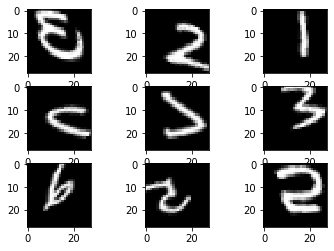

In [4]:
# Rotation range is in degrees. Shear range is 
train_gen = ImageDataGenerator(
    rotation_range = 20,
    shear_range = 30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip = True,
    vertical_flip = True)

for x_batch, y_batch in train_gen.flow(x_train, y_train, batch_size=9):
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(x_batch[i].reshape(28, 28), cmap = plt.get_cmap('gray'))
	plt.show()
	break

Let's set up a generator to transform the training set, and train a model using a random continuous `flow()` of these examples.

In [9]:
# Set up a generator. Params:
# Random rotation between +/- 8 degrees
# Random translations of +/- 8% of total width
# Random zooms of +/- 8% of total size.
# Random shear of +/- 15 degrees
train_gen = ImageDataGenerator(rotation_range = 8, 
                               width_shift_range = 0.08, 
                               shear_range = 15, 
                               height_shift_range = 0.08, 
                               zoom_range = 0.08 )

# Set up a flow from our generator.
train_set = train_gen.flow(x_train_scl, y_train, batch_size = batch_size)

# Set up a second validation flow from the same generator.
val_set = train_gen.flow(x_train_scl, y_train, batch_size=100)

# Set up and compile model.
conv_model = Sequential()
conv_model.add(Reshape((28, 28, 1)))
conv_model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(28,28)))
conv_model.add(Conv2D(64, (3, 3)))
conv_model.add(Activation('relu'))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Dropout(0.2))
conv_model.add(Flatten())
conv_model.add(Dense(128))
conv_model.add(Activation('relu'))
conv_model.add(Dropout(0.5))
conv_model.add(Dense(10))
conv_model.add(Activation('softmax'))

conv_model.compile(optimizer = optim,
              loss = loss_fn,
              metrics = ['accuracy'])

# Validation steps argument only applies when ImageDataGenerator is used.
conv_model.fit(train_set, 
                         steps_per_epoch = 60000//batch_size, 
                         validation_data = val_set, 
                         validation_steps = 10000//batch_size, 
                         epochs = 40)

  ...
    to  
  ['...']
Train for 120 steps, validate for 20 steps
Epoch 1/40
120/120 [==============================] - 15s 128ms/step - loss: 0.6093 - accuracy: 0.8024 - val_loss: 0.1828 - val_accuracy: 0.9485
Epoch 2/40
120/120 [==============================] - 15s 127ms/step - loss: 0.2328 - accuracy: 0.9285 - val_loss: 0.1101 - val_accuracy: 0.9645
Epoch 3/40
120/120 [==============================] - 15s 125ms/step - loss: 0.1807 - accuracy: 0.9456 - val_loss: 0.0777 - val_accuracy: 0.9780
Epoch 4/40
120/120 [==============================] - 15s 129ms/step - loss: 0.1515 - accuracy: 0.9542 - val_loss: 0.0709 - val_accuracy: 0.9750
Epoch 5/40
120/120 [==============================] - 15s 124ms/step - loss: 0.1411 - accuracy: 0.9574 - val_loss: 0.0636 - val_accuracy: 0.9800
Epoch 6/40
120/120 [==============================] - 15s 128ms/step - loss: 0.1320 - accuracy: 0.9600 - val_loss: 0.0507 - val_accuracy: 0.9835
Epoch 7/40
120/120 [==============================] - 15s 126m

Evaluation should yield accuracy of around 99.4%, about 0.4% off the best known classifier. Not too shabby! To boost this much higher, we'd need to complicate the model architecture. I encourage you to check out examples on Kaggle; for instance, [this one hits 99.7% accuracy](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6).

In [11]:
conv_model.evaluate(x_test_scl, y_test)

10000/10000 [==============================] - 1s 94us/sample - loss: 0.0199 - accuracy: 0.9936


[0.019921857891002356, 0.9936]